In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
h5 = pd.HDFStore("/home/pchatha/mimic/data/all_hourly_data.h5")

In [3]:
h5.keys()

['/codes',
 '/interventions',
 '/patients',
 '/vitals_labs',
 '/vitals_labs_mean',
 '/patients/meta/values_block_6/meta',
 '/patients/meta/values_block_5/meta',
 '/patients/meta/values_block_4/meta',
 '/patients/meta/values_block_0/meta']

In [4]:
interventions = h5["interventions"].reset_index()

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Subset to Patient Stays between 16-128 hours

In [6]:
interventions['subject_id'].nunique()

34472

In [7]:
stay_lengths = interventions.groupby("subject_id").size()
stay_lengths = stay_lengths[(stay_lengths >= 16) & (stay_lengths <= 128)]
stay_lengths.name="stay_length"

In [8]:
stay_lengths.describe()

count    30323.000000
mean        51.071398
std         27.902553
min         16.000000
25%         28.000000
50%         45.000000
75%         69.000000
max        128.000000
Name: stay_length, dtype: float64

### Extract Treatment Status

In [9]:
vent = interventions.groupby("subject_id")["vent"].any().astype(int)

In [10]:
vent = vent.to_frame().join(stay_lengths, how="right")

In [11]:
vent['vent'].mean()

0.35438446064043794

In [12]:
vent.groupby("vent")["stay_length"].mean()

vent
0    46.918476
1    58.637167
Name: stay_length, dtype: float64

In [13]:
vent.head()

,vent,stay_length
subject_id,,
4,0,41
6,0,89
9,1,128
11,0,39
13,1,88


### Demographic Data

In [14]:
demog = h5["patients"]

In [15]:
demog = demog[["gender", "age"]]

In [16]:
demog["gender"].value_counts(normalize=True)

M    0.565502
F    0.434498
Name: gender, dtype: float64

In [17]:
d = {"F":0, "M":1}
demog["gender"] = demog["gender"].apply(lambda x: d.get(x))

In [18]:
demog["age"] = demog["age"].clip(upper=90)

In [19]:
demog["age"].describe()

count    34472.000000
mean        63.841678
std         17.590891
min         15.052693
25%         52.466861
50%         65.741463
75%         78.016920
max         90.000000
Name: age, dtype: float64

In [20]:
demog["age"] = (demog["age"] - demog["age"].mean()) / demog["age"].std()

In [21]:
demog["age"].describe()

count    3.447200e+04
mean     2.538682e-14
std      1.000000e+00
min     -2.773537e+00
25%     -6.466311e-01
50%      1.079982e-01
75%      8.058286e-01
max      1.487038e+00
Name: age, dtype: float64

In [22]:
demog = demog.reset_index().set_index("subject_id")[["gender", "age"]]

In [23]:
demog = demog.join(stay_lengths, how="right")

### Get ICD Data

In [24]:
codes = h5["codes"].reset_index()[["subject_id", "icd9_codes"]].drop_duplicates(["subject_id"])

In [25]:
codes = codes.set_index("subject_id").join(stay_lengths, how="right")

In [26]:
codes["icd9_codes"].apply(len).describe()

count    30323.000000
mean        10.542361
std          5.590807
min          1.000000
25%          7.000000
50%          9.000000
75%         13.000000
max         39.000000
Name: icd9_codes, dtype: float64

In [27]:
codes = codes.explode("icd9_codes")

Special ICD9 Codes:
4019: hypertension
41401: coronary atherosclerosis
42731: atrial fibrillation (all more likely in treated group)

### Get Lab Data

In [28]:
vitals = h5["vitals_labs_mean"].droplevel(['hadm_id', 'icustay_id'])
vitals.columns = vitals.columns.get_level_values(0)
vital_list = [
    'heart rate',
    'red blood cell count',
    'sodium',
    'mean blood pressure',
    'systemic vascular resistance',
    'glucose',
    'chloride urine',
    'glascow coma scale total',
    'hematocrit',
    'positive end-expiratory pressure set',
    'respiratory rate',
    'prothrombin time pt',
    'cholesterol',
    'hemoglobin',
    'creatinine',
    'blood urea nitrogen',
    'bicarbonate',
    'calcium ionized',
    'partial pressure of carbon dioxide',
    'magnesium',
    'anion gap',
    'phosphorous',
    'venous pvo2',
    'platelets',
    'calcium urine'
]
vitals = vitals[vital_list]
vitals = vitals.fillna(method="ffill")
vitals = vitals.fillna(method="bfill")

In [29]:
mean = np.mean(vitals, axis=0)
std = np.std(vitals, axis=0)
vitals = (vitals - mean) / std

In [30]:
vitals.head()

LEVEL2               heart rate  red blood cell count    sodium  \
subject_id hours_in                                               
3          0           3.340470             -1.048404  0.841512   
           1           3.956230             -1.048404  0.841512   
           2           3.039750             -1.048404  0.036602   
           3           2.552869             -1.048404  0.036602   
           4           3.512310             -1.048404  0.036602   

LEVEL2               mean blood pressure  systemic vascular resistance  \
subject_id hours_in                                                      
3          0                    1.412524                      0.270765   
           1                   -1.403389                      0.270765   
           2                   -1.028406                      0.270765   
           3                    0.342406                      0.270765   
           4                   -0.151086                      0.270765   

LEVEL2                glucose  chloride urine  glascow coma scale total  \
subject_id hours_in                                                       
3          0         1.272345       -0.857997                 -3.709687   
           1         1.272345       -0.857997                 -3.709687   
           2         2.662503       -0.857997                 -3.709687   
           3         2.662503       -0.857997                 -3.709687   
           4         2.662503       -0.857997                 -3.709687   

LEVEL2               hematocrit  positive end-expiratory pressure set  ...  \
subject_id hours_in                                                    ...   
3          0          -0.885737                              1.091505  ...   
           1          -0.885737                              1.091505  ...   
           2          -0.310961                              1.091505  ...   
           3          -0.310961                              1.091505  ...   
           4          -0.310961                              1.091505  ...   

LEVEL2               blood urea nitrogen  bicarbonate  calcium ionized  \
subject_id hours_in                                                      
3          0                    0.927884     -1.85188        -0.067307   
           1                    0.927884     -1.85188        -0.067307   
           2                    0.927884     -1.85188        -0.054547   
           3                    0.927884     -1.85188        -0.054547   
           4                    0.927884     -1.85188        -0.054547   

LEVEL2               partial pressure of carbon dioxide  magnesium  anion gap  \
subject_id hours_in                                                             
3          0                                  -0.954592   2.404239   2.058697   
           1                                  -0.954592   2.404239   2.058697   
           2                                  -0.846218   2.404239   2.058697   
           3                                  -0.846218   2.404239   2.058697   
           4                                  -0.846218   2.404239   2.058697   

LEVEL2               phosphorous  venous pvo2  platelets  calcium urine  
subject_id hours_in                                                      
3          0            1.356663    -1.136858   0.194868       0.556021  
           1            1.356663    -1.136858   0.194868       0.556021  
           2            1.356663    -1.136858   0.194868       0.556021  
           3            1.356663    -1.136858   0.194868       0.556021  
           4            1.356663    -1.136858   0.194868       0.556021  

[5 rows x 25 columns]

In [31]:
vitals = vitals.join(stay_lengths, how="right")

Confounding vitals: heart rate, hematocrit, platelets, hemoglobin

<AxesSubplot:>

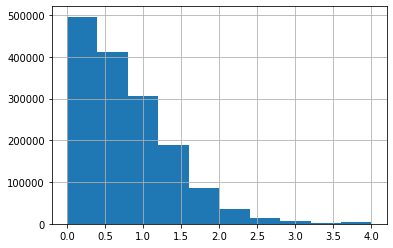

In [32]:
(np.abs(vitals["heart rate"])).clip(upper=4).hist()

# Combine Everything!

In [33]:
df = demog[["gender", "stay_length"]].join(vent["vent"])

In [34]:
df["gender"] = df["gender"].astype(int)

In [35]:
df["stay_length"] = (df["stay_length"] - df["stay_length"].mean()) / df["stay_length"].std()

#### Incorporate Confounding Codes

In [36]:
conf_codes = codes.copy()

In [37]:
conf_codes["hypertension"] = (conf_codes["icd9_codes"] == "4019")
conf_codes["coronary_ath"] = (conf_codes["icd9_codes"] == "41401")
conf_codes["atrial_fib"] = (conf_codes["icd9_codes"] == "42731")

In [38]:
conf_codes = conf_codes.groupby(conf_codes.index)[["hypertension", "coronary_ath", "atrial_fib"]].any().astype(int)

In [39]:
conf_codes.any(axis=1).mean()

0.6264881443128978

63% of patients have at least one of the confounding codes (good!)

In [40]:
df = df.join(conf_codes)

In [41]:
conf_vitals = vitals[["hematocrit", "platelets", "hemoglobin"]]

In [42]:
conf_vitals = conf_vitals.groupby(level=0).last()

In [43]:
df = df.join(conf_vitals)

In [44]:
df.groupby(["vent"]).mean()

,gender,stay_length,hypertension,coronary_ath,atrial_fib,hematocrit,platelets,hemoglobin
vent,,,,,,,,
0,0.535935,-0.148837,0.400368,0.203249,0.201972,0.179270,0.079008,0.165932
1,0.624232,0.271150,0.508003,0.407873,0.280663,-0.190599,-0.240027,-0.149825


In [45]:
df.head()

,gender,stay_length,vent,hypertension,coronary_ath,atrial_fib,hematocrit,platelets,hemoglobin
subject_id,,,,,,,,,
4,0,-0.360949,0,0,0,0,0.018405,0.413658,-0.111641
6,0,1.359324,0,0,0,0,0.890256,-0.393352,0.933756
9,1,2.757045,1,1,0,0,1.006502,1.059265,1.043798
11,0,-0.432627,0,0,0,0,0.851507,0.279156,0.988777
13,0,1.323485,1,1,1,0,-0.969693,-0.976192,-1.046996


In [46]:
def sim_data(df):
    assert (df.columns == ['gender', 'stay_length', 'vent', 'hypertension', 'coronary_ath',
       'atrial_fib', 'hematocrit', 'platelets', 'hemoglobin']).all()
    

In [47]:
np.random.seed(28)
beta = np.random.choice([1,2], size=8, p=[.75, .25])
beta = beta * [1, 1, 1, 1, 1, -1, -1, -1]
beta

array([ 1,  1,  1,  1,  2, -1, -1, -2])

In [48]:
X = df.drop(columns="vent").to_numpy()

In [49]:
X.shape

(30323, 8)

In [50]:
Z = (X * beta).sum(1)

In [51]:
eta = -3
c = -1
m = 1.3
p = sigmoid(eta * df["vent"] + m*(Z + c))
p0 = sigmoid(m*(Z + c))
p1 = sigmoid(eta + m*(Z + c))

In [52]:
p.mean()

0.4956147097361356

In [53]:
y = np.random.binomial(1, p)
y0 = np.random.binomial(1, p0)
y1 = np.random.binomial(1, p1)

In [54]:
print(y[df["vent"]==1].mean(), y[df["vent"]==0].mean())
print(y1.mean(), y0.mean())

0.49748743718592964 0.49175052357358123
0.3467005243544504 0.5754707647660192


In [55]:
print(p[df["vent"]==1].mean() - p[df["vent"]==0].mean())
print((y1 - y0).mean())

0.010022080230304264
-0.22877024041156876


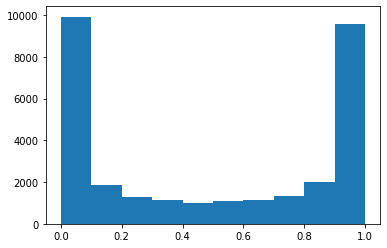

In [56]:
plt.hist(p)
plt.show()

#### Write out Data

In [72]:
df.to_csv("../data/semisynth_covariates.csv", index=True)

In [59]:
import os

In [60]:
os.getcwd()

'/home/pchatha/mimic/notebooks'

In [68]:
df_label_probs = pd.DataFrame(index=df.index)
df_label_probs["p"] = p
df_label_probs["p0"] = p0
df_label_probs["p1"] = p1

In [69]:
df_label_probs.head()

,p,p0,p1
subject_id,,,
4,0.115001,0.115001,0.006428
6,0.068714,0.068714,0.003660
9,0.028882,0.373972,0.028882
11,0.002724,0.002724,0.000136
13,0.994895,0.999745,0.994895


In [71]:
(df_label_probs["p1"] - df_label_probs["p0"]).mean()

-0.22511057888061312

In [74]:
df_label_probs.to_csv("../data/outcome_probs.csv")